# Planet GMM + Suzuki draws: coverage and diagnostics

This notebook explores the conditional (i, phi, P) model trained as a binned-GMM conditioned on (s, q), and visualizes:

- s/q bin heat maps (counts per bin from training data)
- A few per-bin GMM visualizations
- A 10k-planet Suzuki draw with appended (i, phi, P), including distribution plots

Notes:
- We ignore detectability weights per the current approach.
- Artifact path is relative to this repo; update if you moved it.
- Plots are quick-look diagnostics, not publication-ready.

In [21]:
# Setup
import os
import sys
import math
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit nicer
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

# Robust repo/paths resolution for notebooks (no __file__)
CWD = Path.cwd()

# Try to detect gulls-planets directory from common launch locations
PLANETS_DIR = None
if CWD.name == "notebooks" and (CWD.parent / "binned_gmm_artifact.pkl").exists():
    PLANETS_DIR = CWD.parent
else:
    p = CWD
    for _ in range(5):
        if (p / "gulls-planets").is_dir():
            PLANETS_DIR = p / "gulls-planets"
            break
        p = p.parent
    if PLANETS_DIR is None:
        # Fallback: assume current dir is within gulls-planets
        PLANETS_DIR = CWD if (CWD / "binned_gmm_artifact.pkl").exists() else CWD.parent

ROOT = PLANETS_DIR.parent if PLANETS_DIR != PLANETS_DIR.parent else CWD
ARTIFACT_PATH = PLANETS_DIR / "binned_gmm_artifact.pkl"
SUZUKI_SCRIPT = PLANETS_DIR / "suzuki_draw_planet_arrays.py"

print(f"CWD: {CWD}")
print(f"PLANETS_DIR: {PLANETS_DIR}")
print(f"ARTIFACT_PATH exists: {ARTIFACT_PATH.exists()}")
print(f"SUZUKI_SCRIPT exists: {SUZUKI_SCRIPT.exists()}")

CWD: /fs/project/gaudi.1/amber/gulls_posteriors/gulls-planets/notebooks
PLANETS_DIR: /fs/project/gaudi.1/amber/gulls_posteriors/gulls-planets
ARTIFACT_PATH exists: True
SUZUKI_SCRIPT exists: True


In [22]:
# Load artifact and helpers
import pickle

ARTIFACT = None
if ARTIFACT_PATH.exists():
    with open(ARTIFACT_PATH, "rb") as f:
        ARTIFACT = pickle.load(f)
    print("Loaded artifact with keys:", list(ARTIFACT.keys()))
else:
    print("Artifact not found; some cells below will be skipped.")

# Expected keys in artifact (per train_binned_gmm.py)
# - 'xs_edges': np.ndarray of log10(s) bin edges
# - 'xq_edges': np.ndarray of log10(q) bin edges
# - 'models': dict mapping (ix, iq) -> {'gmm': GaussianMixture, 'count': int, 'xs_range': (lo, hi), 'xq_range': (lo, hi)}

# Safety helpers

def ensure_artifact(artifact):
    if artifact is None:
        raise RuntimeError("Artifact not loaded; please train or point ARTIFACT_PATH correctly.")
    for k in ["xs_edges", "xq_edges", "models"]:
        if k not in artifact:
            raise RuntimeError(f"Artifact missing key: {k}")
    return artifact


def find_bin_indices(s_vals, q_vals, xs_edges, xq_edges):
    # Convert to log10 and digitize against edges
    ls = np.log10(np.asarray(s_vals))
    lq = np.log10(np.asarray(q_vals))
    ix = np.clip(np.digitize(ls, xs_edges) - 1, 0, len(xs_edges) - 2)
    iq = np.clip(np.digitize(lq, xq_edges) - 1, 0, len(xq_edges) - 2)
    return ix, iq

Loaded artifact with keys: ['xs_edges', 'xq_edges', 'models', 'transforms']


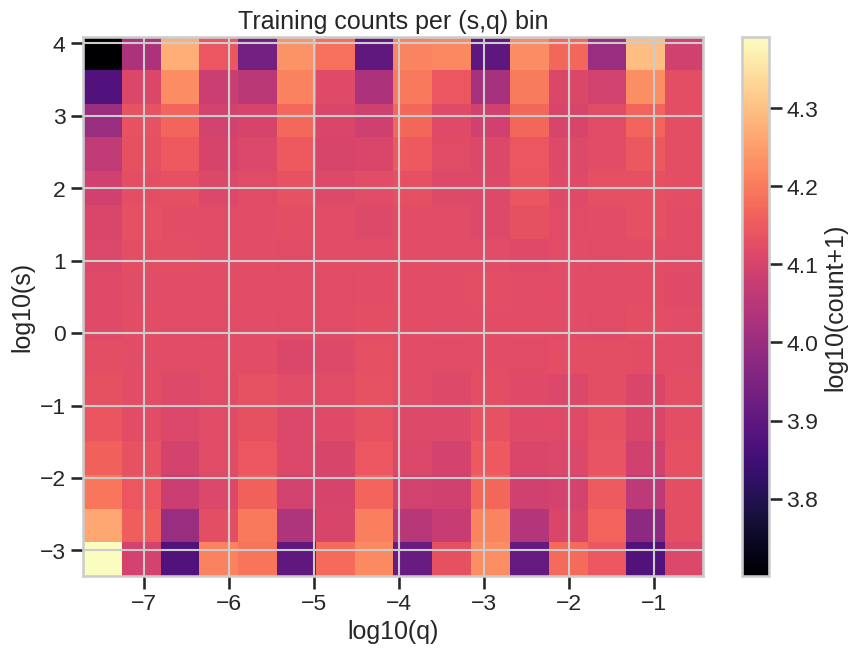

In [23]:
# Heat map of s/q bin counts from artifact
if ARTIFACT is not None:
    ensure_artifact(ARTIFACT)
    models = ARTIFACT["models"]
    xs_edges = ARTIFACT["xs_edges"]
    xq_edges = ARTIFACT["xq_edges"]

    nx = len(xs_edges) - 1
    nq = len(xq_edges) - 1
    counts = np.zeros((nx, nq), dtype=int)

    for (ix, iq), entry in models.items():
        n = entry.get("count")
        if n is None:
            # try X length if present; otherwise 0
            X = entry.get("X")
            n = 0 if X is None else len(X)
        counts[ix, iq] = int(n)

    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(
        np.log10(counts + 1),
        origin="lower",
        aspect="auto",
        cmap="magma",
        extent=[xq_edges[0], xq_edges[-1], xs_edges[0], xs_edges[-1]],
    )
    cbar = fig.colorbar(im, ax=ax, label="log10(count+1)")
    ax.set_xlabel("log10(q)")
    ax.set_ylabel("log10(s)")
    ax.set_title("Training counts per (s,q) bin")
    plt.show()
else:
    print("Skip: artifact not loaded")

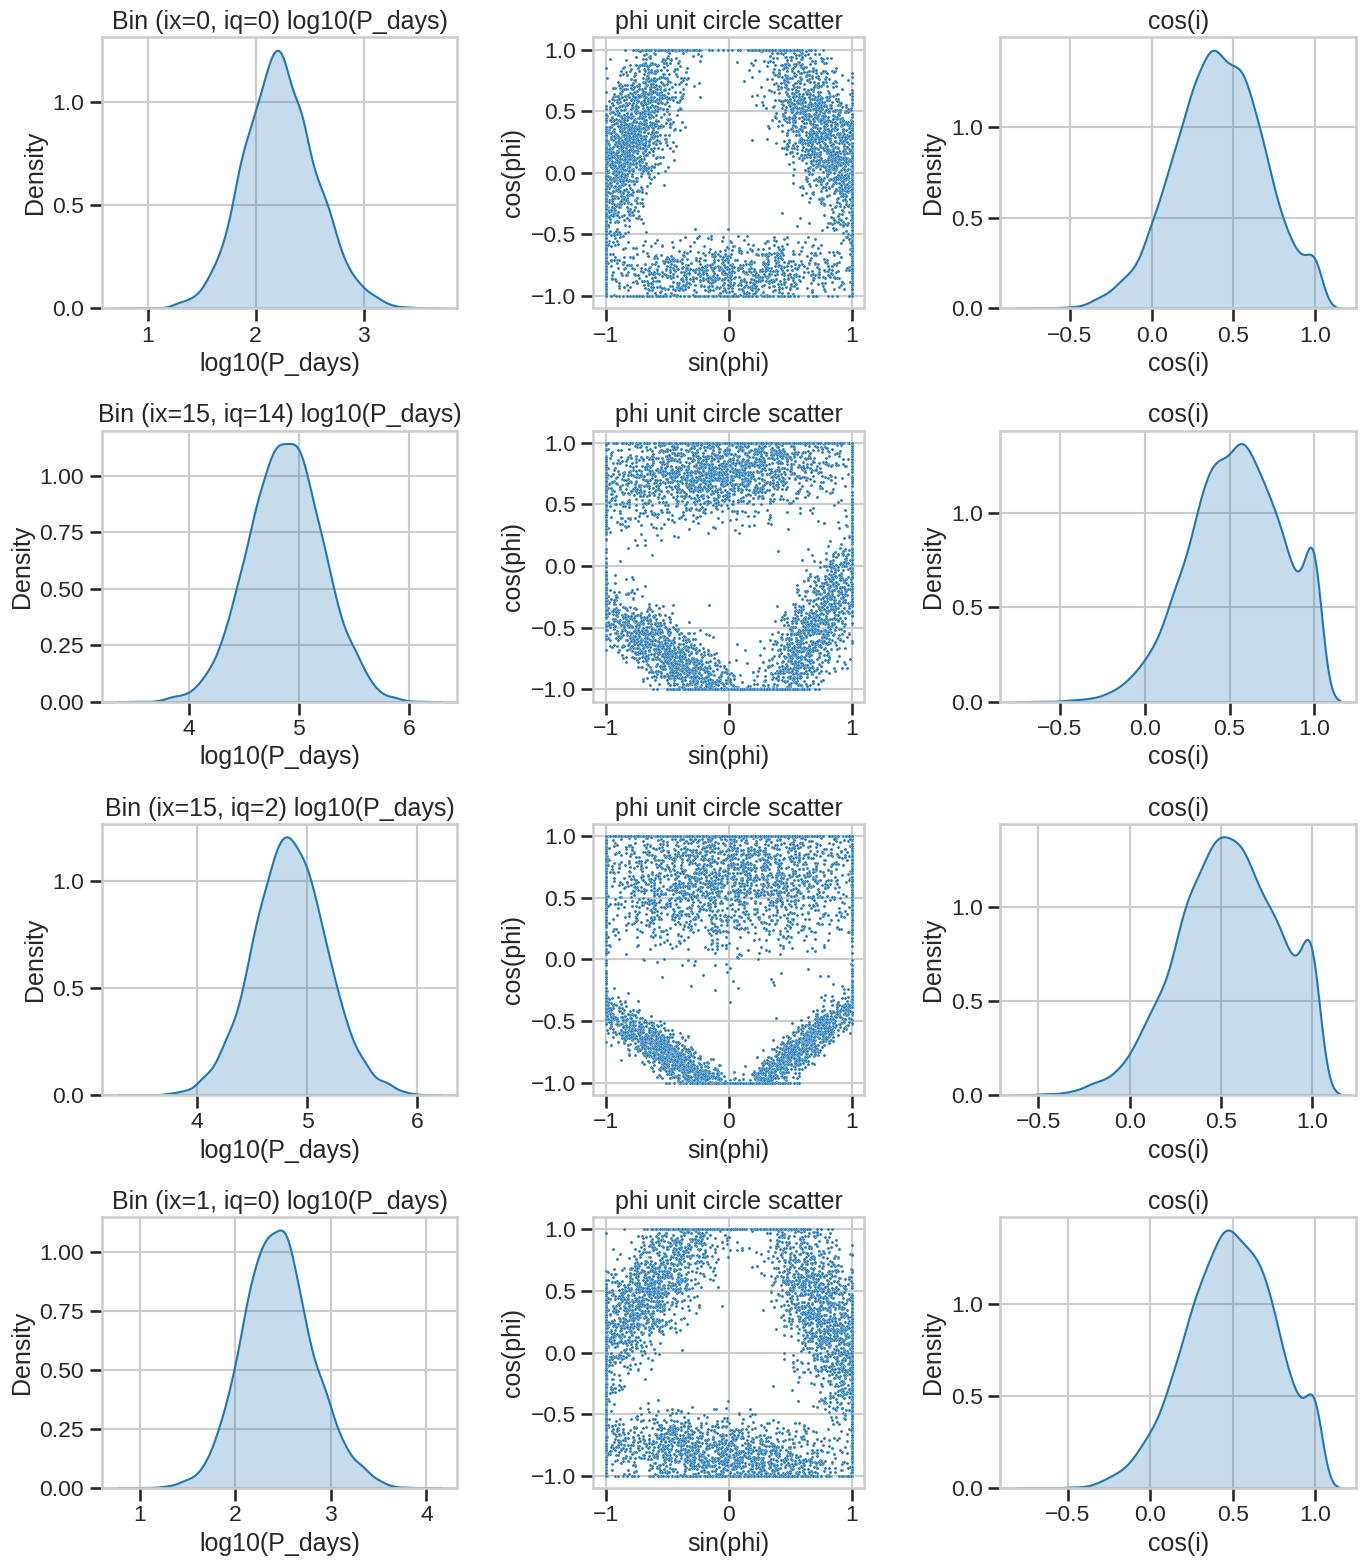

In [24]:
# Inspect a few non-empty bins with per-bin GMM projections
if ARTIFACT is not None:
    ensure_artifact(ARTIFACT)
    models = ARTIFACT["models"]

    # Pick up to 4 bins with the largest counts that actually have a GMM
    populated = [
        (key, entry) for key, entry in models.items()
        if isinstance(entry, dict) and entry.get("gmm") is not None
    ]
    populated.sort(key=lambda kv: (kv[1].get("count") or 0), reverse=True)
    picked = populated[:4]

    if not picked:
        print("No non-empty bins with GMMs found in artifact.")
    else:
        rows = len(picked)
        fig, axes = plt.subplots(rows, 3, figsize=(14, 4*rows))
        if rows == 1:
            axes = np.array([axes])

        for row, ((ix, iq), entry) in enumerate(picked):
            gmm = entry["gmm"]
            n_est = entry.get("count") or 2000
            n_draw = int(min(5000, max(1000, n_est)))
            S = gmm.sample(n_draw)[0]
            # S columns: [mu=cos(i), sin_phi, cos_phi, log10(P_days)]
            mu = np.clip(S[:, 0], -1.0, 1.0)
            sin_phi = np.clip(S[:, 1], -1.0, 1.0)
            cos_phi = np.clip(S[:, 2], -1.0, 1.0)
            log10_Pd = S[:, 3]

            # Plot log10(P_days)
            sns.kdeplot(x=log10_Pd, fill=True, ax=axes[row, 0])
            axes[row, 0].set_title(f"Bin (ix={ix}, iq={iq}) log10(P_days)")
            axes[row, 0].set_xlabel("log10(P_days)")

            # Phi unit circle scatter
            sns.scatterplot(x=sin_phi, y=cos_phi, s=5, ax=axes[row, 1])
            axes[row, 1].set_title("phi unit circle scatter")
            axes[row, 1].set_xlabel("sin(phi)")
            axes[row, 1].set_ylabel("cos(phi)")
            axes[row, 1].set_aspect("equal")

            # cos(i)
            sns.kdeplot(x=mu, fill=True, ax=axes[row, 2])
            axes[row, 2].set_title("cos(i)")
            axes[row, 2].set_xlabel("cos(i)")

        plt.tight_layout()
        plt.show()
else:
    print("Skip: artifact not loaded")

In [25]:
# Create a 10k Suzuki draw (q, s) and append (i, phi, P) using the artifact
# This cell assumes the Suzuki script is present but we'll just create a synthetic (q,s) set
N = 10_000
rng = np.random.default_rng(123)

# Quick synthetic Suzuki-like sample in log10 space (placeholder if you don't want to execute external script)
# Uniform box; adjust if you prefer the real sampler
ls = rng.uniform(-0.5, 0.5, size=N)  # log10(s) ~ U[-0.5, 0.5] => s ~ [0.316, 3.16]
lq = rng.uniform(-6.0, -2.0, size=N) # log10(q) ~ U[-6, -2]

s_vals = 10**ls
q_vals = 10**lq

print("Synthetic Suzuki-like sample created:", {
    "s_min": float(s_vals.min()),
    "s_max": float(s_vals.max()),
    "q_min": float(q_vals.min()),
    "q_max": float(q_vals.max()),
})

samples = None
if ARTIFACT is not None:
    ensure_artifact(ARTIFACT)
    xs_edges = ARTIFACT["xs_edges"]
    xq_edges = ARTIFACT["xq_edges"]
    models = ARTIFACT["models"]

    ix, iq = find_bin_indices(s_vals, q_vals, xs_edges, xq_edges)

    # Batch by bin for efficiency
    results = np.zeros((N, 3))  # i_deg, phi_deg, P_years
    missing = 0

    for (bx, bq) in np.unique(np.stack([ix, iq], axis=1), axis=0):
        mask = (ix == bx) & (iq == bq)
        entry = models.get((int(bx), int(bq)))
        if entry is None or entry.get("gmm") is None:
            missing += int(mask.sum())
            continue
        gmm = entry["gmm"]
        Xs = gmm.sample(int(mask.sum()))[0]
        # Xs: [mu=cos(i), sin(phi), cos(phi), log10(P_days)]
        mu = np.clip(Xs[:, 0], -1.0, 1.0)
        i_deg = np.degrees(np.arccos(mu))

        sin_phi = np.clip(Xs[:, 1], -1.0, 1.0)
        cos_phi = np.clip(Xs[:, 2], -1.0, 1.0)
        phi_deg = (np.degrees(np.arctan2(sin_phi, cos_phi)) + 360.0) % 360.0

        log10_Pd = Xs[:, 3]
        P_years = 10**log10_Pd / 365.25

        results[mask, 0] = i_deg
        results[mask, 1] = phi_deg
        results[mask, 2] = P_years

    print(f"Bins missing GMMs: {missing} of {N} samples")
    samples = pd.DataFrame({
        "s": s_vals,
        "q": q_vals,
        "i_deg": results[:, 0],
        "phi_deg": results[:, 1],
        "P_years": results[:, 2],
    })
else:
    print("Skip: artifact not loaded")

Synthetic Suzuki-like sample created: {'s_min': 0.31624358590165375, 's_max': 3.1613729468650194, 'q_min': 1.0001481806679107e-06, 'q_max': 0.009995349482509264}
Bins missing GMMs: 0 of 10000 samples


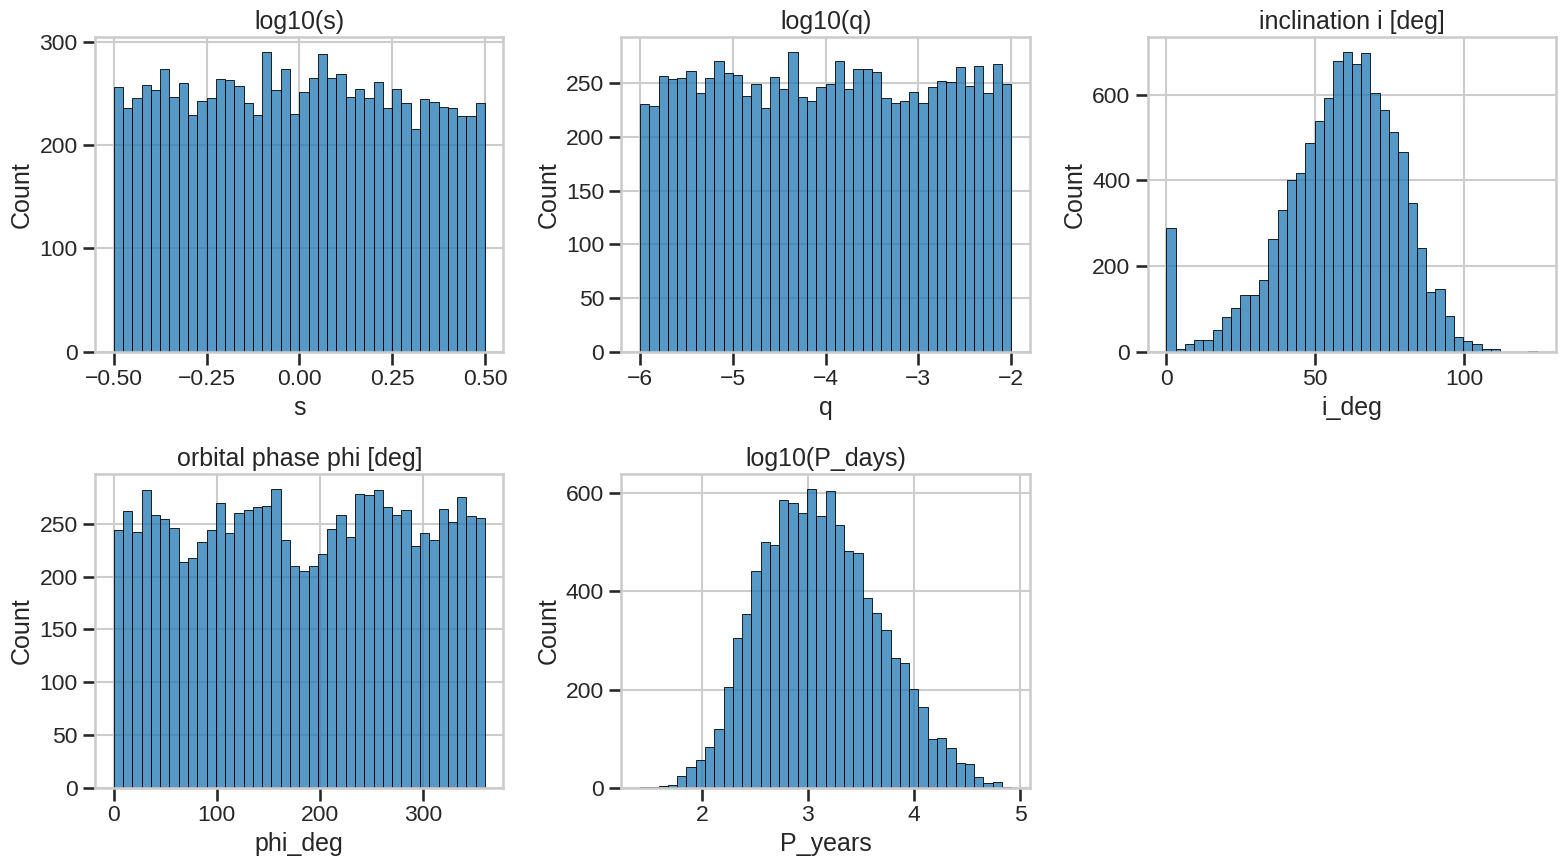

In [26]:
# Distribution plots for the 10k sample
if 'samples' in globals() and samples is not None:
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))

    sns.histplot(np.log10(samples['s']), bins=40, ax=axes[0,0])
    axes[0,0].set_title('log10(s)')

    sns.histplot(np.log10(samples['q']), bins=40, ax=axes[0,1])
    axes[0,1].set_title('log10(q)')

    sns.histplot(samples['i_deg'], bins=40, ax=axes[0,2])
    axes[0,2].set_title('inclination i [deg]')

    sns.histplot(samples['phi_deg'] % 360.0, bins=40, ax=axes[1,0])
    axes[1,0].set_title('orbital phase phi [deg]')

    sns.histplot(np.log10(samples['P_years']*365.25), bins=40, ax=axes[1,1])
    axes[1,1].set_title('log10(P_days)')

    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Skip: no samples to plot")

## Troubleshooting

- If ARTIFACT_PATH exists is False, confirm the file `gulls-planets/binned_gmm_artifact.pkl` is present in the repo. Adjust `ARTIFACT_PATH` above if you moved it.
- If you see many "Bins missing GMMs" in the 10k sample, it likely means some (s,q) bins were empty in training. You can increase bin width (fewer bins) when training or enable nearest-bin fallback in your sampler.
- To use the real Suzuki generator outputs instead of the synthetic sample here, run your generator separately or ask me to wire an optional cell that invokes `suzuki_draw_planet_arrays.py` and reads the resulting CSVs.

### Artifact schema note

This notebook expects the artifact format created by `train_binned_gmm.py`:
- `xs_edges` (array): edges in log10(s)
- `xq_edges` (array): edges in log10(q)
- `models` (dict): keyed by (ix, iq) with entries like `{ 'gmm': GaussianMixture, 'count': N, 'xs_range': (lo, hi), 'xq_range': (lo, hi) }`

If your artifact has keys like `bins`/`S`/`Q`, it’s from an earlier prototype. Two options:
- Re-train using `train_binned_gmm.py` (recommended), or
- Adapt the notebook cells to your legacy schema by mapping `bins['s_edges'] -> xs_edges`, `bins['q_edges'] -> xq_edges`, and `models` accordingly.

## Why are log10(s) and log10(q) uniform above?

Because the earlier demo cell deliberately drew a synthetic sample with `log10(s) ~ U[-0.5, 0.5]` and `log10(q) ~ U[-6, -2]` as a placeholder. Below is an alternative that draws (s, q) from the artifact’s empirical bin counts (i.e., approximating the training distribution), then samples (i, phi, P) from each bin’s GMM.

In [27]:
# Artifact-weighted (s,q) sampler: draws (s,q) by empirical bin counts and appends (i, phi, P)
N = 10_000
if ARTIFACT is not None:
    ensure_artifact(ARTIFACT)
    xs_edges = ARTIFACT["xs_edges"]
    xq_edges = ARTIFACT["xq_edges"]
    models = ARTIFACT["models"]

    # Build weights per fitted bin
    keys = []
    weights = []
    for key, entry in models.items():
        c = entry.get("count") or 0
        gmm = entry.get("gmm")
        if gmm is None or c <= 0:
            continue
        keys.append(key)
        weights.append(c)

    weights = np.asarray(weights, dtype=float)
    wsum = weights.sum()
    if wsum <= 0:
        raise RuntimeError("No fitted bins with positive counts found.")
    probs = weights / wsum

    rng = np.random.default_rng(321)
    picks = rng.choice(len(keys), size=N, p=probs)

    s_vals = np.empty(N)
    q_vals = np.empty(N)
    i_vals = np.empty(N)
    phi_vals = np.empty(N)
    P_vals = np.empty(N)

    for idx_bin in np.unique(picks):
        mask = (picks == idx_bin)
        (ix, iq) = keys[idx_bin]
        entry = models[(ix, iq)]
        gmm = entry["gmm"]

        # Draw targets
        Xs = gmm.sample(int(mask.sum()))[0]
        mu = np.clip(Xs[:,0], -1.0, 1.0)
        i_deg = np.degrees(np.arccos(mu))
        sin_phi = np.clip(Xs[:,1], -1.0, 1.0)
        cos_phi = np.clip(Xs[:,2], -1.0, 1.0)
        phi_deg = (np.degrees(np.arctan2(sin_phi, cos_phi)) + 360.0) % 360.0
        log10_Pd = Xs[:,3]
        P_years = 10**log10_Pd / 365.25

        # Draw inputs uniformly within the chosen bin’s rectangle
        xs_lo, xs_hi = ARTIFACT['xs_edges'][ix], ARTIFACT['xs_edges'][ix+1]
        xq_lo, xq_hi = ARTIFACT['xq_edges'][iq], ARTIFACT['xq_edges'][iq+1]
        ls = rng.uniform(xs_lo, xs_hi, size=int(mask.sum()))
        lq = rng.uniform(xq_lo, xq_hi, size=int(mask.sum()))

        s_vals[mask] = 10**ls
        q_vals[mask] = 10**lq
        i_vals[mask] = i_deg
        phi_vals[mask] = phi_deg
        P_vals[mask] = P_years

    samples_weighted = pd.DataFrame({
        's': s_vals,
        'q': q_vals,
        'i_deg': i_vals,
        'phi_deg': phi_vals,
        'P_years': P_vals,
    })
    print("Artifact-weighted sample generated.")
else:
    print("Skip: artifact not loaded")

Artifact-weighted sample generated.
